# Лобанова Валерия 310

### Сравнить cамое популярное итальянское Sangiovese, французское Burgundy, и калифорнийское Pinot Noir (не самое популяное, но оно там есть)

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

In [3]:
data = pd.read_csv ("winemag-data-130k-v2.csv")

df = data[['country', 'points', 'price', 'province', 'variety', 'taster_name']]
df.to_csv ('wine.csv', index = False)

dataNew = pd.read_csv ("wine.csv")

In [4]:
def is_Italy_Sangiovese (x, y):
    if type (x) == str and type (y) == str:
        return ('Italy' == x and 'Sangiovese' in y)           
    return False

def is_France_Burgundy (x, y):
    if type (x) == str and type (y) == str:
        return ('France' == x and 'Burgundy' in y)             
    return False

def is_California_PinotNoir (x, y):
    if type (x) == str and type (y) == str:
        return ('California' == x and 'Pinot Noir' in y)             
    return False

Analyzed_set = dataNew.groupby (
    dataNew.apply (
        lambda x: is_Italy_Sangiovese (x['country'], x['variety']) 
            or is_France_Burgundy (x['country'], x['province'])
            or is_California_PinotNoir (x['province'], x['variety']), axis = 1))

Analyzed_set = Analyzed_set.get_group (True)
Analyzed_set = Analyzed_set.dropna (axis = 0)

In [26]:
def get_group_number (country, province, variety):
    if is_Italy_Sangiovese (country, variety):
        return 1
    elif is_France_Burgundy (country, province):
        return 2
    elif is_California_PinotNoir (province, variety):
        return 3
    return 0

Analyzed_set['GN'] = Analyzed_set.apply (
    lambda x: get_group_number (x['country'], x['province'], x['variety']), axis = 1)

for i in range (1, 4):
    print ('len group %d = %d' % (i, len (Analyzed_set.groupby('GN').get_group (i))), end = ', ')

len group 1 = 1496, len group 2 = 3090, len group 3 = 4017, 

In [27]:
Analyzed_set['pointsbyprice'] = Analyzed_set.apply (lambda x: x['points'] / (10 + np.log (x['price'])), axis = 1)
Analyzed_set

,country,points,price,province,variety,taster_name,GN,pointsbyprice
25,US,87,69.0,California,Pinot Noir,Virginie Boone,3,6.112080
61,Italy,86,17.0,Central Italy,Sangiovese,Kerin O’Keefe,1,6.701361
65,France,86,24.0,Burgundy,Chardonnay,Roger Voss,2,6.526002
66,France,86,15.0,Burgundy,Chardonnay,Roger Voss,2,6.767364
98,Italy,88,30.0,Tuscany,Sangiovese,Kerin O’Keefe,1,6.566577
...,...,...,...,...,...,...,...,...
129888,US,91,34.0,California,Pinot Noir,Matt Kettmann,3,6.727604
129892,Italy,91,72.0,Tuscany,Sangiovese,Kerin O’Keefe,1,6.374037
129912,US,91,55.0,California,Pinot Noir,Virginie Boone,3,6.496597
129931,France,91,107.0,Burgundy,Pinot Noir,Roger Voss,2,6.201940


Проверим равенство дисперсий:

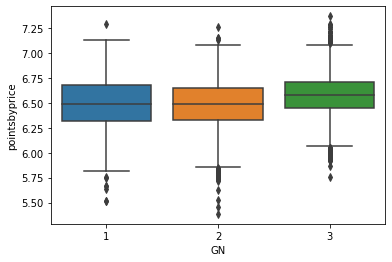

In [28]:
sns.boxplot (y = Analyzed_set['pointsbyprice'], x = Analyzed_set['GN']);
plt.show()

In [29]:
stats.levene (Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 1],
              Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 2],
              Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 3])

LeveneResult(statistic=107.0738278849379, pvalue=1.1693849360987563e-46)

$p_{value} < 0.05\;\Rightarrow$ отвергается равенство дисперсий.

Я пробовала изменять функцию, считающую pointsbyprice - гомоскедастичности добиться не получилось.

Значит не можем применять ни метод ANOVA, ни метод Краскела-Уоллиса.

Проверим выборки на нормальность:

In [30]:
stats.shapiro (Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 1])

ShapiroResult(statistic=0.9957444667816162, pvalue=0.0003272376488894224)

In [31]:
stats.shapiro (Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 2])

ShapiroResult(statistic=0.9885052442550659, pvalue=4.015025531961319e-15)

In [32]:
stats.shapiro (Analyzed_set['pointsbyprice'][Analyzed_set['GN'] == 3])

ShapiroResult(statistic=0.9971978068351746, pvalue=9.101748332795978e-07)

$p_{value} < 0.05\;$ во всех выборках $\Rightarrow$ нормальность отвергается.

Применим Хи-квадрат тест:

In [33]:
Analyzed_set_crosstab = pd.crosstab (Analyzed_set['pointsbyprice'],  Analyzed_set['GN'], margins = False) 

sp.stats.chi2_contingency (Analyzed_set_crosstab)

(4868.706977888463,
 1.1316631679078765e-158,
 2476,
 array([[0.17389283, 0.35917703, 0.46693014],
        [0.17389283, 0.35917703, 0.46693014],
        [0.34778566, 0.71835406, 0.93386028],
        ...,
        [0.17389283, 0.35917703, 0.46693014],
        [0.34778566, 0.71835406, 0.93386028],
        [0.17389283, 0.35917703, 0.46693014]]))

Получается, что чисто по оценкам различия есть.